# Análisis de un chat grupal de WhatsApp

Hacer este análisis ayuda a ver cuáles son las palabras más utilizadas por persona, los temas que se hablan, cuánto escribe cada uno, etc. <br>Además, se pueden hacer series de tiempo para predecir a futuro quién hablará e incluso el posible tema que tocará. <br>Se puede hacer un sentiment analysis para entender si son positivos o negativos los mensajes.

In [1]:
#Primero se cargan las librerías a usar:
library(timeDate)
library(dplyr) #Manipulación de Datos
library(stringr)
library(ggplot2) #Gráficas
library(plotly) #Más gráficas
library(lubridate) #Limpiar Fechas
library(tm)#Analisis de datos
library(wordcloud)
#Si no las tienes instaladas, usa la línea de código: install.packages("Nombre de la librería")

Warning message:
"package 'dplyr' was built under R version 3.5.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'stringr' was built under R version 3.5.3"
Attaching package: 'plotly'

The following object is masked from 'package:ggplot2':

    last_plot

The following object is masked from 'package:stats':

    filter

The following object is masked from 'package:graphics':

    layout


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Loading required package: NLP

Attaching package: 'NLP'

The following object is masked from 'package:ggplot2':

    annotate

Loading required package: RColorBrewer


Se carga el texto del chat grupal. Dado que es un archivo TXT se carga como tabla. <br>
En este punto la tabla solamente tiene una columna porque el programa no sabe dónde dividir el texto de cada fila, por default se llamará esta columna "V1".

In [2]:
base <- read.table("https://raw.githubusercontent.com/Manamaster/analisisWhatsApp/master/chatWA.txt", header=FALSE, sep="|", quote="", encoding='UTF-8')
head(base)

V1
[14/03/19 13:56:16] Networking BTL & Mkt: <U+200E>Los mensajes en este grupo ahora están protegidos con cifrado de extremo a extremo.
[14/03/19 13:56:16] <U+200E><U+202A>+52 1 55 3100 5236<U+202C> creó este grupo
[14/03/19 14:15:31] <U+200E><U+202A>+52 1 55 3100 5236<U+202C> te añadió
"[14/03/19 14:16:43] <U+202A>+52 1 55 1333 1488<U+202C>: Hola a todos y gracias Giovana. Soy Lizeth Guerrero, actualmente estamos en búsqueda en la agencia de un Campaign Specialist de Google Ads, alguien que opere algunos de nuestros clientes y optimice campañas, si saben de alguien porfa avisenme, gracias"
[14/03/19 14:19:25] <U+200E><U+202A>+52 1 55 3100 5236<U+202C> añadió a <U+202A>+52 1 55 5075 7577<U+202C>
"[14/03/19 14:20:57] <U+202A>+52 1 81 8252 7465<U+202C>: Hola a todos, buena tarde. Soy Carlos Rodríguez, asesor y consultor de medios para Grupo Multimedios, Grupo Milenio y Grupo Pol. Vendo medios, asesoro marcas y creo campañas para todas las plataformas de la empresa para la que trabajo. Estoy en Monterrey pero puedo ver clientes de todo el país."


## Se separan los datos
### Creación de variable fecha
Se usan los números que se tomarán para la fecha son del 1 al 20, dado que ese es el largo de la fecha: <br>
[14/03/19 13:56:16] <br>
Se extraen de V1, nombre por default de la columna extraida del TXT.

In [3]:
base$fecha <- gsub("\\.","",substr(base$V1, 1, 20)) #gsub busca un caracter y lo reemplaza.
head(base)

V1,fecha
[14/03/19 13:56:16] Networking BTL & Mkt: <U+200E>Los mensajes en este grupo ahora están protegidos con cifrado de extremo a extremo.,[14/03/19 13:56:16]
[14/03/19 13:56:16] <U+200E><U+202A>+52 1 55 3100 5236<U+202C> creó este grupo,[14/03/19 13:56:16]
[14/03/19 14:15:31] <U+200E><U+202A>+52 1 55 3100 5236<U+202C> te añadió,[14/03/19 14:15:31]
"[14/03/19 14:16:43] <U+202A>+52 1 55 1333 1488<U+202C>: Hola a todos y gracias Giovana. Soy Lizeth Guerrero, actualmente estamos en búsqueda en la agencia de un Campaign Specialist de Google Ads, alguien que opere algunos de nuestros clientes y optimice campañas, si saben de alguien porfa avisenme, gracias",[14/03/19 14:16:43]
[14/03/19 14:19:25] <U+200E><U+202A>+52 1 55 3100 5236<U+202C> añadió a <U+202A>+52 1 55 5075 7577<U+202C>,[14/03/19 14:19:25]
"[14/03/19 14:20:57] <U+202A>+52 1 81 8252 7465<U+202C>: Hola a todos, buena tarde. Soy Carlos Rodríguez, asesor y consultor de medios para Grupo Multimedios, Grupo Milenio y Grupo Pol. Vendo medios, asesoro marcas y creo campañas para todas las plataformas de la empresa para la que trabajo. Estoy en Monterrey pero puedo ver clientes de todo el país.",[14/03/19 14:20:57]


Extraemos la parte de la persona y su mensaje

In [4]:
base<-base %>%
  mutate(texto=gsub("\\.:",":",substring(V1, 21)))%>%
  select(-V1)

Se elimina el primer registro, ya que no contribuye. <br>
Si existieran más líneas que no sirven (como aquellas donde dice: "Tal persona agregó a tal persona") se puede usar el código de esta manera:<br> "base[1:#,] <- NA", donde "#" es el número de fila hasta donde se borrará.

In [5]:
base[1,] <- NA

Se remueven los emoji y se mantiene el texto. <br>
Para esto se crea una columna nueva llamada "texto".

In [6]:
base$texto <- gsub("[^0-9A-Za-z///:áéíóúñ']"," " , base$texto ,ignore.case = TRUE)

Se cambian todos a mayúsculas para que no haga triplicados de palabras.

In [7]:
base$texto <- toupper(base$texto)

Se reemplazan los acentos con vocales sin acentos.

In [8]:
base$texto <- chartr('ÁÉÍÓÚ', 'AEIOU', base$texto)

Remover puntuación, palabras innecesarias y espacios en blanco. <br>
Las "stopwords" son palabras comunes que no son necesarias para el análisis del texto. 

In [9]:
head(base)

fecha,texto
NA,NA
[14/03/19 13:56:16],52 1 55 3100 5236 CREO ESTE GRUPO
[14/03/19 14:15:31],52 1 55 3100 5236 TE AÑADIO
[14/03/19 14:16:43],52 1 55 1333 1488 : HOLA A TODOS Y GRACIAS GIOVANA SOY LIZETH GUERRERO ACTUALMENTE ESTAMOS EN BUSQUEDA EN LA AGENCIA DE UN CAMPAIGN SPECIALIST DE GOOGLE ADS ALGUIEN QUE OPERE ALGUNOS DE NUESTROS CLIENTES Y OPTIMICE CAMPAÑAS SI SABEN DE ALGUIEN PORFA AVISENME GRACIAS
[14/03/19 14:19:25],52 1 55 3100 5236 AÑADIO A 52 1 55 5075 7577
[14/03/19 14:20:57],52 1 81 8252 7465 : HOLA A TODOS BUENA TARDE SOY CARLOS RODRIGUEZ ASESOR Y CONSULTOR DE MEDIOS PARA GRUPO MULTIMEDIOS GRUPO MILENIO Y GRUPO POL VENDO MEDIOS ASESORO MARCAS Y CREO CAMPAÑAS PARA TODAS LAS PLATAFORMAS DE LA EMPRESA PARA LA QUE TRABAJO ESTOY EN MONTERREY PERO PUEDO VER CLIENTES DE TODO EL PAIS


In [10]:
base$texto <- removeWords(base$texto, c(toupper(stopwords("spanish")),
                                              'OK', 'JAJA', 'JAJAJA', 'JAJAJAJA', 'MEDIA OMITTED'))
base$texto <- stripWhitespace(base$texto)
base$persona <- gsub(":.+$", "", base$texto)
base$mensaje <- gsub("^.+:", "", base$texto)

In [11]:
head(base)

fecha,texto,persona,mensaje
NA,NA,NA,NA
[14/03/19 13:56:16],52 1 55 3100 5236 CREO GRUPO,52 1 55 3100 5236 CREO GRUPO,52 1 55 3100 5236 CREO GRUPO
[14/03/19 14:15:31],52 1 55 3100 5236 AÑADIO,52 1 55 3100 5236 AÑADIO,52 1 55 3100 5236 AÑADIO
[14/03/19 14:16:43],52 1 55 1333 1488 : HOLA GRACIAS GIOVANA LIZETH GUERRERO ACTUALMENTE BUSQUEDA AGENCIA CAMPAIGN SPECIALIST GOOGLE ADS ALGUIEN OPERE CLIENTES OPTIMICE CAMPAÑAS SI SABEN ALGUIEN PORFA AVISENME GRACIAS,52 1 55 1333 1488,HOLA GRACIAS GIOVANA LIZETH GUERRERO ACTUALMENTE BUSQUEDA AGENCIA CAMPAIGN SPECIALIST GOOGLE ADS ALGUIEN OPERE CLIENTES OPTIMICE CAMPAÑAS SI SABEN ALGUIEN PORFA AVISENME GRACIAS
[14/03/19 14:19:25],52 1 55 3100 5236 AÑADIO 52 1 55 5075 7577,52 1 55 3100 5236 AÑADIO 52 1 55 5075 7577,52 1 55 3100 5236 AÑADIO 52 1 55 5075 7577
[14/03/19 14:20:57],52 1 81 8252 7465 : HOLA BUENA TARDE CARLOS RODRIGUEZ ASESOR CONSULTOR MEDIOS GRUPO MULTIMEDIOS GRUPO MILENIO GRUPO POL VENDO MEDIOS ASESORO MARCAS CREO CAMPAÑAS TODAS PLATAFORMAS EMPRESA TRABAJO MONTERREY PUEDO VER CLIENTES PAIS,52 1 81 8252 7465,HOLA BUENA TARDE CARLOS RODRIGUEZ ASESOR CONSULTOR MEDIOS GRUPO MULTIMEDIOS GRUPO MILENIO GRUPO POL VENDO MEDIOS ASESORO MARCAS CREO CAMPAÑAS TODAS PLATAFORMAS EMPRESA TRABAJO MONTERREY PUEDO VER CLIENTES PAIS


Se hace un filtro para quitar los espacios vacíos en la variable mensaje y la palabra "añadió" del número (Cuando un usuario agrega a otro)

In [12]:
base <- base %>% 
  filter(!is.na(mensaje) | mensaje !="") %>% 
  filter(!str_detect(persona, 'AÑADIO')) %>% 
  filter(!str_detect(persona, 'ELIMINO'))

In [13]:
head(base)

fecha,texto,persona,mensaje
[14/03/19 13:56:16],52 1 55 3100 5236 CREO GRUPO,52 1 55 3100 5236 CREO GRUPO,52 1 55 3100 5236 CREO GRUPO
[14/03/19 14:16:43],52 1 55 1333 1488 : HOLA GRACIAS GIOVANA LIZETH GUERRERO ACTUALMENTE BUSQUEDA AGENCIA CAMPAIGN SPECIALIST GOOGLE ADS ALGUIEN OPERE CLIENTES OPTIMICE CAMPAÑAS SI SABEN ALGUIEN PORFA AVISENME GRACIAS,52 1 55 1333 1488,HOLA GRACIAS GIOVANA LIZETH GUERRERO ACTUALMENTE BUSQUEDA AGENCIA CAMPAIGN SPECIALIST GOOGLE ADS ALGUIEN OPERE CLIENTES OPTIMICE CAMPAÑAS SI SABEN ALGUIEN PORFA AVISENME GRACIAS
[14/03/19 14:20:57],52 1 81 8252 7465 : HOLA BUENA TARDE CARLOS RODRIGUEZ ASESOR CONSULTOR MEDIOS GRUPO MULTIMEDIOS GRUPO MILENIO GRUPO POL VENDO MEDIOS ASESORO MARCAS CREO CAMPAÑAS TODAS PLATAFORMAS EMPRESA TRABAJO MONTERREY PUEDO VER CLIENTES PAIS,52 1 81 8252 7465,HOLA BUENA TARDE CARLOS RODRIGUEZ ASESOR CONSULTOR MEDIOS GRUPO MULTIMEDIOS GRUPO MILENIO GRUPO POL VENDO MEDIOS ASESORO MARCAS CREO CAMPAÑAS TODAS PLATAFORMAS EMPRESA TRABAJO MONTERREY PUEDO VER CLIENTES PAIS
[14/03/19 14:21:18],52 1 55 3100 5236 : AGRADECER IDEA CONVERTIRNOS GRUPO COMPARTIR EXPERIENCIAS OPORTUNIDADES HACER GRAN NETWORKING CLIENTES MEDIOS PROVEEDORES BIENVENIDOS VOY SEGUIR SUMANDO MAS CONTACTOS AFORTUNADAMENTE BUENA RESPUESTA POST,52 1 55 3100 5236,AGRADECER IDEA CONVERTIRNOS GRUPO COMPARTIR EXPERIENCIAS OPORTUNIDADES HACER GRAN NETWORKING CLIENTES MEDIOS PROVEEDORES BIENVENIDOS VOY SEGUIR SUMANDO MAS CONTACTOS AFORTUNADAMENTE BUENA RESPUESTA POST
[14/03/19 14:22:23],52 1 81 1075 9259 : HOLA LIZETH PUEDO RECOMENDARTE AGENCIA TRABAJADO FUNCIONAL,52 1 81 1075 9259,HOLA LIZETH PUEDO RECOMENDARTE AGENCIA TRABAJADO FUNCIONAL
[14/03/19 14:23:31],52 1 55 7969 6159 : HOLA NUEVAMENTE EDUARDO MILLAN MERCODOLOGO ACTUALMENTE ENCUENTRO LABORANDO CONSULTORIA INVESTIGACION MERCADOS,52 1 55 7969 6159,HOLA NUEVAMENTE EDUARDO MILLAN MERCODOLOGO ACTUALMENTE ENCUENTRO LABORANDO CONSULTORIA INVESTIGACION MERCADOS


Borrar todos los mensajes vacíos si la columna "mensaje" = ""

In [14]:
base <- base %>% filter(!is.na(mensaje)|mensaje!="")

Creación de columna con formato date

In [15]:
base$fecha <- gsub("[^0-9A-Za-z///_áéíóúñ']","", base$fecha)
base$date <- as.Date(base$fecha, format = "%d/%m/%y")
class(base$date)

[1] "Date"

¿Quiénes son los participantes de este grupo de chat?

In [16]:
unique(factor(base$persona))
length(unique(base$persona))

[1]  52 1 55 3100 5236 CREO GRUPO                                                                                                                                                                                                                                                                                                                                                                             
  [2]  52 1 55 1333 1488                                                                                                                                                                                                                                                                                                                                                                                        
  [3]  52 1 81 8252 7465                                                                                                                                                                                                                                                                                                                                                                                        
  [4]  52 1 55 3100 5236                                                                                                                                                                                                                                                                                                                                                                                        
  [5]  52 1 81 1075 9259                                                                                                                                                                                                                                                                                                                                                                                        
  [6]  52 1 55 7969 6159                                                                                                                                                                                                                                                                                                                                                                                        
  [7]  52 1 55 8176 2819                                                                                                                                                                                                                                                                                                                                                                                        
  [8]  52 1 55 7488 4140 SALIO GRUPO                                                                                                                                                                                                                                                                                                                                                                            
  [9]  52 1 55 1384 0387                                                                                                                                                                                                                                                                                                                                                                                        
 [10]  52 1 55 3332 0749                                                                                                                                                                                                                                                                                                                                                                                 

[1] 748

En este punto podemos determinar si el código ha funcionado con el dataset. ¿Cómo se determina esto? <br>
* Los datos que aparecen con el código "unique(factor(base$persona))" son solamente los números de teléfono o los nombres con los que se tienen registrados a los participantes de la conversación.
* No hay texto además de los nombres o números.

De ser así se puede continuar, sino, hay que observar si el corte fue el adecuado al momento de separar las columas "persona" y "mensaje"

## Análisis de los datos
Se toman a las personas que se quieran analizar:

In [19]:
levels(base$persona) <- c("52 1 55 1333 1488", "52 1 81 8252 7465", "52 1 81 1075 9259")

Se grafica la frecuencia de chateo de los participantes obtenidos en el paso anterior.

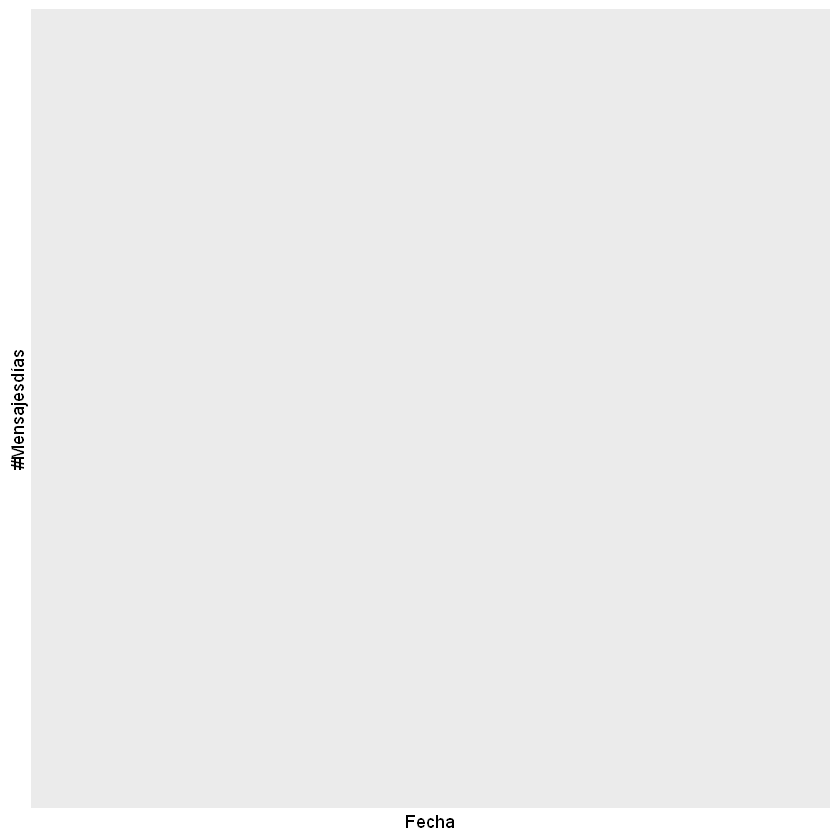

In [20]:
base <- base %>% filter(persona %in% c("52 1 55 1333 1488", "52 1 81 8252 7465", "52 1 81 1075 9259"))
ggplot(base, aes(x=date,fill=persona))+
  geom_histogram(binwidth = 7, position = 'dodge')+
  xlab("Fecha")+ylab("#Mensajesdías")+
  labs(fill="")

¿Cómo saber qué es lo que más comunmente ha dicho una persona?<br>
Para conseguir esto se generará una nube de palabras (wordcloud), a mayor tamaño de una palabra, más veces ha sido dicha por la persona que se está analizando. <br>Si hay muchas palabras como "jajajaja" se pueden remover en el paso 10 donde se agregaron manualmente las stopwords, para que no influyan en el resultado de la nube de palabras. <br>Si se quiere cambiar el color de las palabras en la nube se modifica la última sección del código, específicamente la palabra "Dark2". Para ver las paletas de colores disponibles entra aquí: https://www.nceas.ucsb.edu/~frazier/RSpatialGuides/colorPaletteCheatsheet.pdf 

In [22]:
base_f <- base %>%
  filter(persona=="52 1 55 1288 3515")
dd <- data.frame(
  doc_id=base_f$persona,
  text=base_f$mensaje,
  stringsAsFactors = F
)

base1 <- VCorpus(DataframeSource(dd),
                 readerControl = list(language = "es"))
dtm <- DocumentTermMatrix(base1)


freq = data.frame(sort(colSums(as.matrix(dtm)), decreasing=TRUE))
dev.new()
wordcloud(rownames(freq), freq[,1], max.words=50, colors=brewer.pal(1, "Dark2"))

Warning message in brewer.pal(1, "Dark2"):
"minimal value for n is 3, returning requested palette with 3 different levels
"Warning message in max(freq):
"no non-missing arguments to max; returning -Inf"Warning message in max(freq):
"no non-missing arguments to max; returning -Inf"

ERROR: Error in strwidth(words[i], cex = size[i], ...): invalid 'cex' value
